In [99]:
import numpy as np
import pandas as pd
import re
import geopandas
import matplotlib.pyplot as plt
from shapely import wkt
import datetime as dt

In [100]:
#La principal caracteristica de esta funcion es permitir ocultar o mostrar ciertas columnas.
#Por si sola NO elimina columnas del dataframe (podria pero no es para lo que esta desarrollada).
def update_columns(func:str, col_name:str, col_list:list):
    if func == 'add' and col_name not in col_list:
        col_list.append(col_name)
    elif func == 'del' and col_name in col_list:
        col_list.remove(col_name)

In [101]:
def split_coordinates(col_name:str, dataframe, new_sufix:str="", inplace:bool=True):
    new_sufix = col_name if new_sufix == "" else new_sufix
    dataframe[new_sufix + "_x"] = [float(re.findall(r"\d{1,2}\.\d*", x)[0]) for x in dataframe[col_name]]
    dataframe[new_sufix + "_y"] = [float(re.findall(r"\d{1,2}\.\d*", x)[1]) for x in dataframe[col_name]]
    if not(inplace):
        return dataframe.copy()

def split_datetime(col_name:str, dataframe, inplace:bool=True):
    dataframe["date"] = [ (dt.strptime(x, "%Y-%m-%d %H:%M:%S")).date() for x in dataframe[col_name]]
    dataframe["time"] = [(dt.strptime(x, "%Y-%m-%d %H:%M:%S")).time() for x in dataframe[col_name]]
    if not(inplace):
        return dataframe.copy()

In [102]:
df_raw_data = pd.read_csv('trips.csv')
columns_to_show = list(df_raw_data.columns.copy())
update_columns('del', 'datasource', columns_to_show)
df_raw_data.head()[columns_to_show]

,region,origin_coord,destination_coord,datetime
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54


In [103]:
#Preprocesamiento y filtrado de columnas que no seran utilizadas
#Separacion de los puntos en sus componentes (probable criterio para identificar cercania)
split_coordinates("origin_coord", df_raw_data, "origin")
split_coordinates("destination_coord", df_raw_data, "dest")

#update_columns es solo para visualizacion, despues de que todo este correcto se pueden borrar
update_columns('del', 'origin_coord', columns_to_show)
update_columns('add', 'origin_x', columns_to_show)
update_columns('add', 'origin_y', columns_to_show)
update_columns('del', 'destination_coord', columns_to_show)
update_columns('add', 'dest_x', columns_to_show)
update_columns('add', 'dest_y', columns_to_show)

df_raw_data.head()[columns_to_show]

,region,datetime,origin_x,origin_y,dest_x,dest_y
0,Prague,2018-05-28 09:03:40,14.497379,50.001369,14.431095,50.040529
1,Turin,2018-05-21 02:54:04,7.672838,44.995711,7.720369,45.067824
2,Prague,2018-05-13 08:52:25,14.324273,50.000021,14.477679,50.093398
3,Turin,2018-05-06 09:49:16,7.541509,45.091605,7.745287,45.026286
4,Turin,2018-05-23 12:45:54,7.614078,45.134331,7.527497,45.033351


In [104]:
df_raw_data['Coordinates'] = geopandas.GeoSeries.from_wkt(df_raw_data['destination_coord'])
gdf = geopandas.GeoDataFrame(df_raw_data, geometry='Coordinates')

In [105]:
df_raw_data['Geom_origin'] = df_raw_data.origin_coord.apply(wkt.loads)
gdf = geopandas.GeoDataFrame(df_raw_data, geometry='Geom_origin')

gdf.head()

,region,origin_coord,destination_coord,datetime,datasource,origin_x,origin_y,dest_x,dest_y,Coordinates,Geom_origin
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car,14.497379,50.001369,14.431095,50.040529,POINT (14.43109 50.04053),POINT (14.49738 50.00137)
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car,7.672838,44.995711,7.720369,45.067824,POINT (7.72037 45.06782),POINT (7.67284 44.99571)
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile,14.324273,50.000021,14.477679,50.093398,POINT (14.47768 50.09340),POINT (14.32427 50.00002)
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles,7.541509,45.091605,7.745287,45.026286,POINT (7.74529 45.02629),POINT (7.54151 45.09161)
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app,7.614078,45.134331,7.527497,45.033351,POINT (7.52750 45.03335),POINT (7.61408 45.13433)


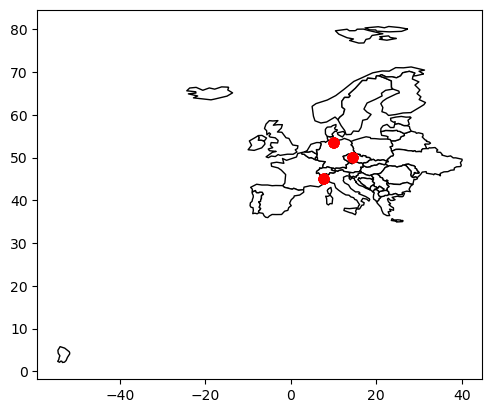

In [106]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
region_mask = (world["continent"]=="Europe") & (world["name"]!="Russia")

ax = world[region_mask].plot(color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')

plt.show()

In [107]:
hour_blocks = []
for hour in range (0,24,3):
    if hour == 21:
        hour_blocks.append((dt.time(hour,0,0), dt.time(23,59,59)))
    else:
        hour_blocks.append((dt.time(hour,0,0), dt.time(hour+3,0,0)))


In [108]:
df_raw_data.datetime = [dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in df_raw_data.datetime]
df_raw_data["time"] = [x.time() for x in df_raw_data.datetime]

In [115]:
df_raw_data["time"]

0     09:03:40
1     02:54:04
2     08:52:25
3     09:49:16
4     12:45:54
        ...   
95    18:56:45
96    12:43:17
97    08:13:09
98    10:39:49
99    22:10:03
Name: time, Length: 100, dtype: object

In [125]:
df_raw_data.groupby([pd.Grouper(key="region"), pd.Grouper(key="datetime", freq="30min")]).count()

origin_coord  destination_coord  datasource  \
region  datetime                                                           
Hamburg 2018-05-01 05:00:00             1                  1           1   
        2018-05-01 10:00:00             1                  1           1   
        2018-05-04 00:30:00             1                  1           1   
        2018-05-05 12:30:00             1                  1           1   
        2018-05-06 06:30:00             1                  1           1   
...                                   ...                ...         ...   
Turin   2018-05-27 09:30:00             1                  1           1   
        2018-05-28 04:00:00             1                  1           1   
        2018-05-29 13:30:00             1                  1           1   
        2018-05-29 15:30:00             1                  1           1   
        2018-05-31 06:00:00             1                  1           1   

                             origin_x  origin_y  dest_x  dest_y  Coordinates  \
region  datetime                                                               
Hamburg 2018-05-01 05:00:00         1         1       1       1            1   
        2018-05-01 10:00:00         1         1       1       1            1   
        2018-05-04 00:30:00         1         1       1       1            1   
        2018-05-05 12:30:00         1         1       1       1            1   
        2018-05-06 06:30:00         1         1       1       1            1   
...                               ...       ...     ...     ...          ...   
Turin   2018-05-27 09:30:00         1         1       1       1            1   
        2018-05-28 04:00:00         1         1       1       1            1   
        2018-05-29 13:30:00         1         1       1       1            1   
        2018-05-29 15:30:00         1         1       1       1            1   
        2018-05-31 06:00:00         1         1       1       1            1   

                             Geom_origin  time  
region  datetime                                
Hamburg 2018-05-01 05:00:00            1     1  
        2018-05-01 10:00:00            1     1  
        2018-05-04 00:30:00            1     1  
        2018-05-05 12:30:00            1     1  
        2018-05-06 06:30:00            1     1  
...                                  ...   ...  
Turin   2018-05-27 09:30:00            1     1  
        2018-05-28 04:00:00            1     1  
        2018-05-29 13:30:00            1     1  
        2018-05-29 15:30:00            1     1  
        2018-05-31 06:00:00            1     1  

[100 rows x 10 columns]

In [126]:
df_raw_data

,region,origin_coord,destination_coord,datetime,datasource,origin_x,origin_y,dest_x,dest_y,Coordinates,Geom_origin,time
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car,14.497379,50.001369,14.431095,50.040529,POINT (14.43109 50.04053),POINT (14.49738 50.00137),09:03:40
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car,7.672838,44.995711,7.720369,45.067824,POINT (7.72037 45.06782),POINT (7.67284 44.99571),02:54:04
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile,14.324273,50.000021,14.477679,50.093398,POINT (14.47768 50.09340),POINT (14.32427 50.00002),08:52:25
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles,7.541509,45.091605,7.745287,45.026286,POINT (7.74529 45.02629),POINT (7.54151 45.09161),09:49:16
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app,7.614078,45.134331,7.527497,45.033351,POINT (7.52750 45.03335),POINT (7.61408 45.13433),12:45:54
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Prague,POINT (14.33562319852013 50.05977285737693),POINT (14.45302412886982 50.06961029075634),2018-05-03 18:56:45,cheap_mobile,14.335623,50.059773,14.453024,50.069610,POINT (14.45302 50.06961),POINT (14.33562 50.05977),18:56:45
96,Hamburg,POINT (9.996714798980491 53.52203690589671),POINT (10.17431393081631 53.51796499041119),2018-05-23 12:43:17,baba_car,9.996715,53.522037,10.174314,53.517965,POINT (10.17431 53.51796),POINT (9.99671 53.52204),12:43:17
97,Prague,POINT (14.40975521275597 50.037791514028),POINT (14.59895464921585 50.05472087955579),2018-05-12 08:13:09,cheap_mobile,14.409755,50.037792,14.598955,50.054721,POINT (14.59895 50.05472),POINT (14.40976 50.03779),08:13:09
98,Hamburg,POINT (10.08338857045871 53.59661344302611),POINT (10.17914017806172 53.60909301795856),2018-05-22 10:39:49,baba_car,10.083389,53.596613,10.179140,53.609093,POINT (10.17914 53.60909),POINT (10.08339 53.59661),10:39:49
